In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
import rainflow
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from stopit import threading_timeoutable as timeoutable
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)
# eSOH_DIR = f"F:/Git Hub rep/PyBaMM/UMBLFeb2022/data/esoh/"
eSOH_DIR = "../UMBLFeb2022/data/esoh_R/"
oCV_DIR = "../UMBLFeb2022/data/ocv/"
fig_DIR = "../figures/figures_fit/"
res_DIR = "../data/results_fit/"
# %matplotlib widget

In [2]:
# parameter_values = get_parameter_values()
parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Andrew2022)

parameter_values.update(
    {
        # mechanical properties
        "Positive electrode Poisson's ratio": 0.3,
        "Positive electrode Young's modulus [Pa]": 375e9,
        "Positive electrode reference concentration for free of deformation [mol.m-3]": 0,
        "Positive electrode partial molar volume [m3.mol-1]": -7.28e-7,
        "Positive electrode volume change": nmc_volume_change_mohtat,
        # Loss of active materials (LAM) model
        "Positive electrode LAM constant exponential term": 2,
        "Positive electrode critical stress [Pa]": 375e6,
        # mechanical properties
        "Negative electrode Poisson's ratio": 0.2,
        "Negative electrode Young's modulus [Pa]": 15e9,
        "Negative electrode reference concentration for free of deformation [mol.m-3]": 0,
        "Negative electrode partial molar volume [m3.mol-1]": 3.1e-6,
        "Negative electrode volume change": graphite_volume_change_mohtat,
        # Loss of active materials (LAM) model
        "Negative electrode LAM constant exponential term": 2,
        "Negative electrode critical stress [Pa]": 60e6,
        # Other
        "Cell thermal expansion coefficient [m.K-1]": 1.48E-6,
        "Lower voltage cut-off [V]": 3.0,
        
   
        # Initializing Particle Concentration
        # "Initial concentration in negative electrode [mol.m-3]": x100*parameter_values["Maximum concentration in negative electrode [mol.m-3]"],
        # "Initial concentration in positive electrode [mol.m-3]": y100*parameter_values["Maximum concentration in positive electrode [mol.m-3]"]
    },
    check_already_exists=False,
)

In [3]:
parameter_values.search("radius")

Negative particle radius [m]	1e-05
Positive particle radius [m]	3.5e-06


In [4]:
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        # "loss of active material": ("stress-driven","none"),
        "loss of active material": "stress-driven",
        # "stress-induced diffusion": "true",
        "lithium plating": "irreversible",
#         "calculate discharge energy":"true"
    }
)

In [5]:
# spm.print_parameter_info()
param=spm.param
parameter_values.update(
    {
"Electrode width [m]":0.1,
#     "Maximum concentration in negative electrode [mol.m-3]":30000,
"Nominal cell capacity [A.h]":2.5,
"Maximum concentration in positive electrode [mol.m-3]":37500,
        
# Updating since February 2022        
"Negative electrode porosity":0.3,
"Positive electrode thickness [m]":5.45e-05,
# "Electrode width [m]" : 0.11,      
     
    }
)

In [6]:
cell = 152002 # calendar

In [19]:
# cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
# eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
# # Temp
cell_no,dfe,N,dfo_0 = load_data_calendar(cell,eSOH_DIR,oCV_DIR)
eps_n_data,eps_p_data,SOC_0,Temp = init_exp_calendar(cell_no,dfe,param,parameter_values)

# cell_no,dfe,N,dfo_0 = load_data_calendar(cell,eSOH_DIR,oCV_DIR)
# eps_n_data,eps_p_data,SOC_0,Temp = init_exp_calendar(cell_no,dfe,param,parameter_values)
# T
# Temp


In [20]:
eps_n_data

0.6519905177417546

In [9]:
 parameter_values.search("Reference temperature")

Reference temperature [K]	298.15


In [21]:
# pybamm.set_logging_level("WARNING")
pybamm.set_logging_level("NOTICE")
experiment = pybamm.Experiment(
    [
        ("Charge at 1C until 4.2V", 
         "Hold at 4.2V until C/50",
         "Rest for 10 min",
         "Discharge at 1C until 3V",
         "Rest for 10 min",)
    ] *10,
    termination="50% capacity",
#     cccv_handling="ode",
)
experiment2 = pybamm.Experiment(
    [
        ("Rest for 24 hours",)
    ] *10,
    termination="50% capacity",
#     cccv_handling="ode",
)
experiment3 = pybamm.Experiment(
    [
        ("Charge at 1C until 4.2V", 
         "Hold at 4.2V until C/20",
         "Rest for 10 min",
         "Discharge at 1C until 3.7V",
         "Rest for 80 min",)
    ] *10,
    termination="50% capacity",
#     cccv_handling="ode",
)

experiment4 = pybamm.Experiment(
    [
        ("Rest for 24 hours",
)
    ] *10,
    termination="50% capacity",
#     cccv_handling="ode",
)


# eps_p_data

In [22]:
Temp=45
# Temp=25

In [23]:
# parameter_values = get_parameter_values()
parameter_values.update(
    {
#         "Negative electrode active material volume fraction": eps_n_data,
#         "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
#         "Positive electrode LAM constant proportional term [s-1]": 8.3747149e-08,#1.27152e-07
        "Positive electrode LAM constant proportional term [s-1]": 7.6504e-08,#10.0638e-08, #8e-08,#1.27152e-07
        "Negative electrode LAM constant proportional term [s-1]":8.7598e-08, #9.078886e-08,#1.27272e-06
        "Positive electrode LAM constant exponential term": 1.02,
        "Negative electrode LAM constant exponential term": 1.02,
        "SEI kinetic rate constant [m.s-1]":1.77495878e-15,# 4.352126e-16, #4.1964e-16, #4.60788219e-16, 1.08494281e-16 , 
        "EC diffusivity [m2.s-1]":3.07e-20 ,# 3.6864e-21, #6.6582e-19, #4.56607447e-19,8.30909086e-19,
        "SEI growth activation energy [J.mol-1]": 0.0, #6.02602e+03, #1.87422275e+04,1.58777981e+04,
#         "Lithium plating kinetic rate constant [m.s-1]": 0,
        "Initial inner SEI thickness [m]": 0e-09,
        "Initial outer SEI thickness [m]": 5e-09,
        "SEI resistivity [Ohm.m]": 1.3e03,    #1e06, #3.0e+05,
        "Lithium plating kinetic rate constant [m.s-1]":4.639e-10, #4.50936e-10,
        
        #Cathode disolution
        "Positive electrode dissolution exchange current density":  5.85e-4,
#         "Positive electrode dissolution exchange current density": 0,
        "Negative electrode dissolution exchange current density": 0,
        
        "Positive electrode dissolution nickel SEI coefficient": 0,
        "Negative electrode dissolution nickel SEI coefficient": 0.1,
        
        "Positive electrode dissolution nickel intercalation coefficient": 0,
        "Negative electrode dissolution nickel intercalation coefficient": 0.1,
        
        
        
        
        
        
        
    },
    check_already_exists=False,
)

In [24]:
sim_long3 = pybamm.Simulation(spm, experiment=experiment3, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe",
                            rtol=1e-6, 
                            atol=1e-6,
                            dt_max=10,
                                                      ))
sol_long3 = sim_long3.solve(initial_soc=0.5, save_at_cycles=20  )


2023-06-01 12:32:41.028 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/10 (13.067 ms elapsed) --------------------
2023-06-01 12:32:41.028 - [NOTICE] callbacks.on_step_start(182): Cycle 1/10, step 1/5: Charge at 1C until 4.2V
2023-06-01 12:32:41.166 - [NOTICE] callbacks.on_step_start(182): Cycle 1/10, step 2/5: Hold at 4.2V until C/20
2023-06-01 12:32:41.337 - [NOTICE] callbacks.on_step_start(182): Cycle 1/10, step 3/5: Rest for 10 min
2023-06-01 12:32:41.417 - [NOTICE] callbacks.on_step_start(182): Cycle 1/10, step 4/5: Discharge at 1C until 3.7V
2023-06-01 12:32:41.547 - [NOTICE] callbacks.on_step_start(182): Cycle 1/10, step 5/5: Rest for 80 min
2023-06-01 12:32:41.770 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 1.989 Ah (originally 1.989 Ah, will stop at 0.994 Ah)
2023-06-01 12:32:41.771 - [NOTICE] callbacks.on_cycle_start(174): Cycle 2/10 (756.242 ms elapsed) --------------------
2023-06-01 12:32:41.771 - [NOTICE] callbacks.on_step_start(182): Cycle 2/10, step 1/5: 

In [16]:
 parameter_values.search("area")

Cell cooling surface area [m2]	0.41


In [17]:
# sim_long3.plot(
#     [
# #         "Negative particle surface concentration [mol.m-3]",
# #         "Electrolyte concentration [mol.m-3]",
#         "Positive particle surface concentration [mol.m-3]",
#         "Current [A]",
# #         "Negative electrode potential [V]",
# #         "Electrolyte potential [V]",
# #         "Positive electrode potential [V]",
#         "Terminal voltage [V]",
# #         "X-averaged cell temperature",
#         "Negative electrode SOC",
#         "Positive electrode SOC",
#         "Throughput capacity [A.h]"

#     ]
# )

In [30]:
# pybamm.plot_summary_variables(sol_long3)

In [31]:
# summary_long3=sol_long3.summary_varabales

In [32]:
sim_long1 = pybamm.Simulation(spm, experiment=experiment4, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe",
                            rtol=1e-6, 
                            atol=1e-6,
                            dt_max=10,
                                                      ))
sol_long1 = sim_long1.solve(initial_soc=0.9, save_at_cycles=10  )

2023-05-11 14:00:49.942 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/30 (80.010 ms elapsed) --------------------
2023-05-11 14:00:49.942 - [NOTICE] callbacks.on_step_start(182): Cycle 1/30, step 1/1: Rest for 24 hours
2023-05-11 14:00:57.529 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.462 Ah (originally 2.462 Ah, will stop at 1.231 Ah)
2023-05-11 14:00:57.539 - [NOTICE] callbacks.on_cycle_start(174): Cycle 2/30 (7.675 s elapsed) --------------------
2023-05-11 14:00:57.539 - [NOTICE] callbacks.on_step_start(182): Cycle 2/30, step 1/1: Rest for 24 hours
2023-05-11 14:01:01.524 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.456 Ah (originally 2.462 Ah, will stop at 1.231 Ah)
2023-05-11 14:01:01.524 - [NOTICE] callbacks.on_cycle_start(174): Cycle 3/30 (11.666 s elapsed) --------------------
2023-05-11 14:01:01.524 - [NOTICE] callbacks.on_step_start(182): Cycle 3/30, step 1/1: Rest for 24 hours
2023-05-11 14:01:05.344 - [NOTICE] callbacks.on_cycle_end(196): Ca

2023-05-11 14:02:31.488 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.388 Ah (originally 2.462 Ah, will stop at 1.231 Ah)
2023-05-11 14:02:31.488 - [NOTICE] callbacks.on_cycle_start(174): Cycle 24/30 (1 minute, 42 seconds elapsed) --------------------
2023-05-11 14:02:31.488 - [NOTICE] callbacks.on_step_start(182): Cycle 24/30, step 1/1: Rest for 24 hours
2023-05-11 14:02:34.751 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.386 Ah (originally 2.462 Ah, will stop at 1.231 Ah)
2023-05-11 14:02:34.751 - [NOTICE] callbacks.on_cycle_start(174): Cycle 25/30 (1 minute, 45 seconds elapsed) --------------------
2023-05-11 14:02:34.751 - [NOTICE] callbacks.on_step_start(182): Cycle 25/30, step 1/1: Rest for 24 hours
2023-05-11 14:02:37.202 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.384 Ah (originally 2.462 Ah, will stop at 1.231 Ah)
2023-05-11 14:02:37.202 - [NOTICE] callbacks.on_cycle_start(174): Cycle 26/30 (1 minute, 47 seconds elapsed) -----------------

In [33]:
sim_long1.plot(
    [
#         "Negative particle surface concentration [mol.m-3]",
#,
        "Total lithium in particles [mol]",
        "Loss of capacity to SEI [A.h]",
        "Terminal voltage [V]",
        "Loss of lithium to SEI [mol]",
        "X-averaged SEI thickness [m]",
        "X-averaged SEI concentration [mol.m-3]",
        "Loss of lithium to SEI [mol]",
          "Negative electrode SEI reaction overpotential [V]",
         "X-averaged negative electrode SEI volumetric interfacial current density",
        "X-averaged negative electrode SEI interfacial current density",
        "X-averaged SEI interfacial current density [A.m-2]",
        "X-averaged outer SEI interfacial current density [A.m-2]",
        "Loss of lithium inventory [%]",
        "X-averaged positive electrode loss nickel dissolution",
        "X-averaged positive electrode dissolution exchange current",
        "X-averaged negative electrode loss nickel dissolution",
        "X-averaged negative electrode dissolution exchange current",        

#         "X-averaged cell temperature",
#         "Negative electrode SOC",
#         "Positive electrode SOC",
#         "Throughput capacity [A.h]"
        "Loss of active material in positive electrode [%]",
        "X-averaged positive electrode active material volume fraction",
#         "Positive particle surface concentration",
#         "R-averaged positive particle concentration",
#         "Positive electrode surface potential difference",
#         "Positive electrode surface potential difference [V]"

        



        
    ]
)

interactive(children=(FloatSlider(value=0.0, description='t', max=720.0000000000006, step=7.2000000000000055),…

In [20]:
LAM_P=sol_long1.summary_variables["Loss of active material in positive electrode [%]"]
LAM_P


array([ 0.05847703,  0.11695405,  0.17543108,  0.2339081 ,  0.29238513,
        0.35086215,  0.40933918,  0.4678162 ,  0.52629323,  0.58477025,
        0.64324728,  0.7017243 ,  0.76020133,  0.81867835,  0.87715538,
        0.9356324 ,  0.99410943,  1.05258646,  1.11106348,  1.16954051,
        1.22801753,  1.28649456,  1.34497158,  1.40344861,  1.46192563,
        1.52040266,  1.57887968,  1.63735671,  1.69583373,  1.75431076,
        1.81278778,  1.87126481,  1.92974183,  1.98821886,  2.04669588,
        2.10517291,  2.16364994,  2.22212696,  2.28060399,  2.33908101,
        2.39755804,  2.45603506,  2.51451209,  2.57298911,  2.63146614,
        2.68994316,  2.74842019,  2.80689721,  2.86537424,  2.92385126,
        2.98232829,  3.04080531,  3.09928234,  3.15775937,  3.21623639,
        3.27471342,  3.33319044,  3.39166747,  3.45014449,  3.50862152,
        3.56709854,  3.62557557,  3.68405259,  3.74252962,  3.80100664,
        3.85948367,  3.91796069,  3.97643772,  4.03491474,  4.09

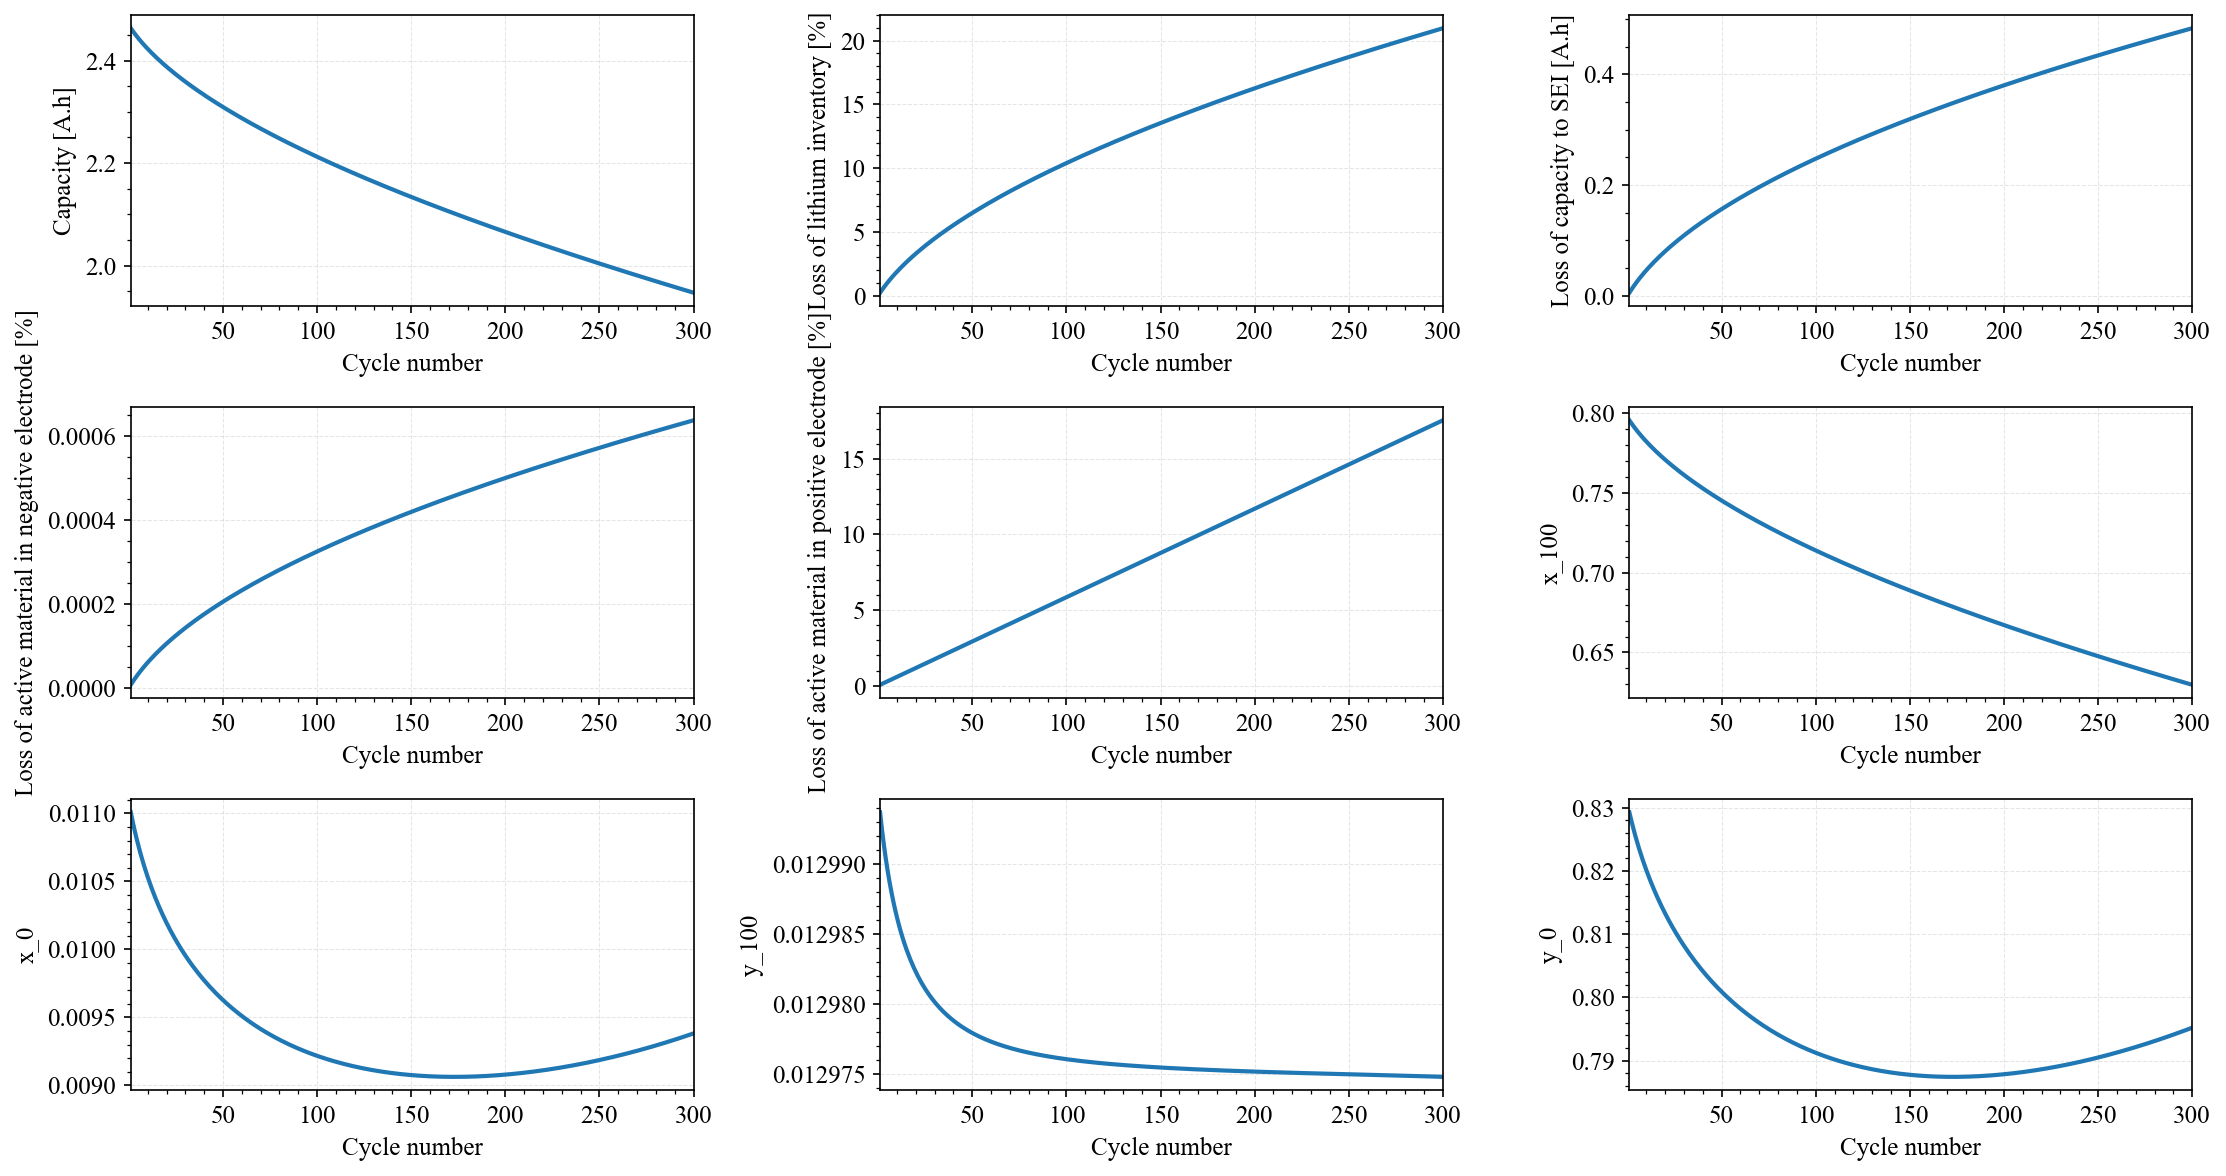

array([[<AxesSubplot: xlabel='Cycle number', ylabel='Capacity [A.h]'>,
        <AxesSubplot: xlabel='Cycle number', ylabel='Loss of lithium inventory [%]'>,
        <AxesSubplot: xlabel='Cycle number', ylabel='Loss of capacity to SEI [A.h]'>],
       [<AxesSubplot: xlabel='Cycle number', ylabel='Loss of active material in negative electrode [%]'>,
        <AxesSubplot: xlabel='Cycle number', ylabel='Loss of active material in positive electrode [%]'>,
        <AxesSubplot: xlabel='Cycle number', ylabel='x_100'>],
       [<AxesSubplot: xlabel='Cycle number', ylabel='x_0'>,
        <AxesSubplot: xlabel='Cycle number', ylabel='y_100'>,
        <AxesSubplot: xlabel='Cycle number', ylabel='y_0'>]], dtype=object)

In [21]:
pybamm.plot_summary_variables(sol_long1)

In [22]:
spm.param.timescale
eadgsdg

NameError: name 'eadgsdg' is not defined

In [ ]:
sim_long11 = pybamm.Simulation(spm, experiment=experiment4, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe",
                            rtol=1e-6, 
                            atol=1e-6,
                            dt_max=10,
                                                      ))
sol_long11 = sim_long11.solve(initial_soc=0.9, save_at_cycles=20  )

In [ ]:
sim_long11.plot(
    [
#         "Negative particle surface concentration [mol.m-3]",
#,
        "Total lithium in particles [mol]",
        "Loss of capacity to SEI [A.h]",
        "Terminal voltage [V]",
        "Loss of lithium to SEI [mol]",
        "X-averaged SEI thickness [m]",
        "X-averaged SEI concentration [mol.m-3]",
        "Loss of lithium to SEI [mol]",
        "Negative electrode SEI reaction overpotential [V]",
         "X-averaged negative electrode SEI volumetric interfacial current density",
        "X-averaged negative electrode SEI interfacial current density",
        "X-averaged SEI interfacial current density [A.m-2]",
        "X-averaged outer SEI interfacial current density [A.m-2]"
        
    ]
)

In [ ]:
pybamm.plot_summary_variables(sol_long11)

In [ ]:
yufiukkgk

In [ ]:
# SOC_0=0.5

# all_sumvars_dict3 = cycle_adaptive_simulation(spm, parameter_values, experiment3,SOC_0, save_at_cycles=1)

In [ ]:
# fig = plotc(all_sumvars_dict3,dfe);


In [ ]:
print(parameter_values.search("max"))
print(parameter_values.search("EC "))
print(parameter_values.search("plating"))
print(parameter_values.search("SEI"))
print(parameter_values.search("LAM"))
print(SOC_0)
print(Temp)


In [ ]:
print(eps_n_data)

In [ ]:
print(eps_p_data)

In [ ]:
# parameter_values.search("")

In [ ]:
# SOC_0=0
# all_sumvars_dict1 = cycle_adaptive_simulation(spm, parameter_values, experiment,SOC_0, save_at_cycles=1)

In [ ]:
# fig = plotc(all_sumvars_dict1,dfe);


In [ ]:

qdqwf


In [ ]:
sol_long=sol_long1
x100=sol_long.summary_variables["x_100"]
y100=sol_long.summary_variables["y_100"]
x0=sol_long.summary_variables["x_0"]
y0=sol_long.summary_variables["y_0"]
Cap=sol_long.summary_variables["Capacity [A.h]"]
LoC_SEI_summ=sol_long.summary_variables["Loss of capacity to SEI [A.h]"]
LAM_P=sol_long.summary_variables["Loss of active material in positive electrode [%]"]
LAM_N=sol_long.summary_variables["Loss of active material in negative electrode [%]"]
C_Neg=sol_long.summary_variables["C_n"]
C_pos=sol_long.summary_variables["C_p"]
LLI=sol_long.summary_variables["Loss of lithium inventory [%]"]
cycle_num=sol_long.summary_variables["Cycle number"]
t = sol_long["Time [s]"].entries
I = sol_long["Current [A]"].entries
Q = sol_long['Discharge capacity [A.h]'].entries
LoC_SEI = sol_long["Loss of capacity to SEI [A.h]"].entries
N_SoC = sol_long["Negative electrode SOC"].entries
P_SoC = sol_long["Positive electrode SOC"].entries
Epsilon_n_s_cycled=sol_long["X-averaged negative electrode active material volume fraction"].entries
Epsilon_p_s_cycled=sol_long["X-averaged positive electrode active material volume fraction"].entries
cycle_time=sol_long.summary_variables['Time [s]'],
Vt_t = sol_long["Terminal voltage [V]"].entries,
delta_SEI=sol_long["X-averaged SEI thickness [m]"].entries

LLI_SEI_mol=sol_long["Loss of lithium to SEI [mol]"].entries,
LLI_plating_mol=sol_long["Loss of lithium to lithium plating [mol]"].entries,

Tot_Li_lost=sol_long["Total lithium lost [mol]"].entries,

In [ ]:
from scipy.io import savemat

ident=""
mdic = {
    "x100"+ident: x100, "y100"+ident:y100, "x0"+ident:x0,"y0"+ident:y0,"Cap"+ident:Cap,
        "LoC_SEI_summ"+ident:LoC_SEI_summ,
        "LAM_P"+ident:LAM_P,"LAM_N"+ident:LAM_N,"C_Neg"+ident:C_Neg,"C_pos"+ident:C_pos,
        "LLI"+ident:LLI,"cycle_num"+ident:cycle_num,
        "t"+ident:t,"LoC_SEI"+ident:LoC_SEI,"N_SoC"+ident:N_SoC,"P_SoC"+ident:P_SoC,
        "Q"+ident:Q, "I"+ident:I,    
#         "ECM_whole_res":ECM_whole_res,"ECM_sum_res":ECM_sum_res,
#         "ECM_sum_res_change":ECM_sum_res_change,"cycle_time":cycle_time 
        "Epsilon_n_s_cycled"+ident:Epsilon_n_s_cycled,
        "Epsilon_p_s_cycled"+ident:Epsilon_p_s_cycled,
        "cycle_time":cycle_time, "Vt_t":Vt_t,
        "LLI_SEI_mol":LLI_SEI_mol,
        "LLI_plating_mol":LLI_plating_mol,
        "delta_SEI":delta_SEI,
        "Tot_Li_lost":Tot_Li_lost
    
       }
savemat("Andrew_dissolution_calendar_difflimited_MECC_Apr11.mat",mdic)

In [ ]:
esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]"]
fig, axes = plt.subplots(3,2,figsize=(7,10))
for k, name in enumerate(esoh_vars):
    ax = axes.flat[k]
    ax.plot(all_sumvars_dict1["Cycle number"],all_sumvars_dict1[name],"k")
    ax.plot(all_sumvars_dict3["Cycle number"],all_sumvars_dict3[name],"g")
    ax.set_title(split_long_string(name))
    if k ==2 or k==3:
        ax.set_ylim([2,4])
    if k>3:
        ax.set_xlabel("Cycle number")
fig.legend(["3V-4.2V"] + ["3.7V-4.2V"], 
       loc="lower center",bbox_to_anchor=[0.5,-0.02], ncol=1, fontsize=11)

In [ ]:
# all_sumvars_dict1

NameError: name 'sol_long1' is not defined

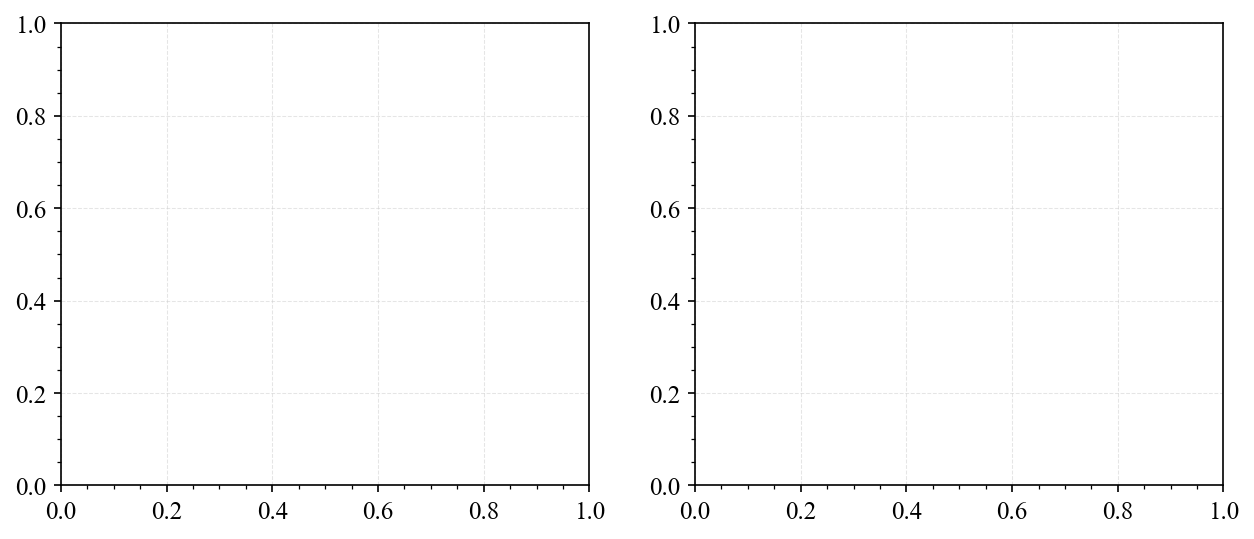

In [16]:
fig, axes = plt.subplots(1,2,figsize=(10,4))
ax = axes.flat[0]
ax.plot(sol_long1.summary_variables["Throughput capacity [A.h]"],sol_long1.summary_variables["Capacity [A.h]"],"k")
ax.plot(sol_long3.summary_variables["Throughput capacity [A.h]"],sol_long3.summary_variables["Capacity [A.h]"],"g")
ax.set_title("Capacity")
# ax.set_ylim([2.9,4.5])
ax.set_xlabel("Throughput (Ah)")

ax = axes.flat[1]
ax.plot(sol_long1.summary_variables["Throughput capacity [A.h]"]/5,sol_long1.summary_variables["Capacity [A.h]"],"k")
ax.plot(sol_long3.summary_variables["Throughput capacity [A.h]"]/5,sol_long3.summary_variables["Capacity [A.h]"],"g")
ax.set_title("Capacity")
# ax.set_ylim([2.9,4.5])
ax.set_xlabel("Discharged capacity/Nominal Capacity (Ah/Ah)")



fig.legend(["3V-4.2V"] + ["3.7V-4.2V"], 
       loc="lower center",bbox_to_anchor=[0.5,-0.02], ncol=1, fontsize=11)




In [ ]:
sol_long1.summary_variables.search("lithium")

In [ ]:
spm.variables.search("area")

In [ ]:
find / -type f -name '*.py' -exec grep -l "keyword" {} \;


In [ ]:
sol_long1["SEI"].entries[-1][1]